In [194]:
import os
import random
import pickle
import zipfile
import numpy as np

#### Load HistWords dataset:

In [195]:
# # dataset obtained from here: https://github.com/williamleif/histwords

# # load dataset here:
# !git clone https://github.com/williamleif/histwords.git
# !wget -O all_english_embeddings.zip "http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip"

# # unzip loaded dataset
# with zipfile.ZipFile("all_english_embeddings.zip", 'r') as zip_ref:
#     zip_ref.extractall("all_english_embeddings")

## Step 1: Load and Preprocess Word Embeddings

In [196]:
# for loading historical embeddings from .npy files
def load_embeddings(file_path):
    return np.load(file_path)

In [197]:
# base dir for embeddings
base_dir = "all_english_embeddings/sgns"
print(os.getcwd()) # debugging

/Users/bryan/Documents/College/Computer Science/CMSC 491 - Modern Regression/Project/code


#### Obtain subsample of words from dataset:

In [198]:
# specify decades of interest
decades = ['1880', '1890', '1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980']
vocab_dict = {}
embeddings_dict = {}
random.seed(42)         # set desired seed here
sample_size = 500       # set desired sample size here

In [199]:
# load and optionally sample each decade's embeddings and vocabulary
for decade in decades:
    # load embeddings
    embedding_path = os.path.join(base_dir, f"{decade}-w.npy")
    embeddings = load_embeddings(embedding_path)
    
    # load vocabulary
    vocab_path = os.path.join(base_dir, f"{decade}-vocab.pkl")
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # ensure embeddings and vocab are same size
    assert len(embeddings) == len(vocab), f"Mismatch in size for {decade}"

    # filter out any numerical values counted as "words"
    filtered_vocab = []
    filtered_embeddings = []
    for word, embedding in zip(vocab, embeddings):
        if not any(char.isdigit() for char in word):
            filtered_vocab.append(word)
            filtered_embeddings.append(embedding)

    # fill dicts
    vocab_dict[decade] = filtered_vocab
    embeddings_dict[decade] = np.array(filtered_embeddings)

#### Filter subsamples by intersection across decades:

In [200]:
# obtain common vocabulary across all decades
common_vocab = set(vocab_dict[decades[0]])
for decade in decades[1:]:
    common_vocab.intersection_update(vocab_dict[decade])

common_vocab = list(common_vocab)  # converted to list for indexing

In [201]:
# precompute word_to_index dictionaries for each decade
word_to_index_dict = {}
for decade in decades:
    vocab = vocab_dict[decade]
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    word_to_index_dict[decade] = word_to_index

# rand sample from common_vocab
initial_sample_size = sample_size * 2  # increase here to account for possible zero vectors
sampled_words = random.sample(common_vocab, min(initial_sample_size, len(common_vocab)))

valid_words = []
zero_vector = np.zeros(embeddings_dict[decades[0]].shape[1])

for word in sampled_words:
    has_zero_vector = False
    for decade in decades:
        idx = word_to_index_dict[decade][word]
        embedding = embeddings_dict[decade][idx]
        if np.array_equal(embedding, zero_vector):
            has_zero_vector = True
            break
    if not has_zero_vector:
        valid_words.append(word)
    if len(valid_words) >= sample_size:
        break  # stop if we have enough valid words

print(f"Number of valid words (non-zero embeddings in all decades): {len(valid_words)}")

# update vocab_dict and embeddings_dict
for decade in decades:
    embeddings = embeddings_dict[decade]
    word_to_index = word_to_index_dict[decade]
    
    # obtain embeddings for valid_words
    indices = [word_to_index[word] for word in valid_words]
    filtered_embeddings = embeddings[indices]
    
    # update dicts with filtered values
    vocab_dict[decade] = valid_words
    embeddings_dict[decade] = filtered_embeddings


Number of valid words (non-zero embeddings in all decades): 260


In [202]:
# debugging
for decade, embeddings in embeddings_dict.items():
    print(f"{decade}'s embeddings:")
    print(f"shape: {embeddings.shape}") # display shape of embeddings per decade
    print(embeddings_dict[decade][:5])  # display first n rows of embeddings per decade
    print()

1880's embeddings:
shape: (260, 300)
[[-0.00067782  0.00995788  0.01206808 ... -0.03244079 -0.06266132
  -0.08732396]
 [ 0.09653023  0.11125836  0.0195283  ... -0.0270584   0.07856242
  -0.03037743]
 [ 0.24247608  0.20400874  0.01872789 ... -0.02989974  0.04552247
  -0.04906598]
 [ 0.01924201 -0.01674615 -0.03748455 ... -0.09349317 -0.05303041
  -0.04856031]
 [-0.03285304 -0.05156624 -0.02515491 ... -0.03201342  0.10005954
  -0.01687687]]

1890's embeddings:
shape: (260, 300)
[[-0.01405528 -0.04208635 -0.02589093 ... -0.02208275  0.01139744
  -0.03502046]
 [ 0.07192218  0.09517407  0.09247126 ... -0.0053563   0.07934791
  -0.02236268]
 [ 0.15060737  0.14044666  0.00543941 ...  0.01979355  0.08450544
  -0.05232438]
 [-0.05123669  0.01843488  0.00494377 ... -0.02576155 -0.10907859
  -0.05718133]
 [-0.05843233  0.03511372 -0.00918816 ...  0.05503963  0.08826871
  -0.01589983]]

1900's embeddings:
shape: (260, 300)
[[-0.0551376   0.04034658 -0.03975978 ... -0.06023822 -0.02169633
  -0.0027

## Step 2: Standardize Data

In [203]:
def standardize(data):
    """
    Manually standardizes data by centering (subtracting mean) and scaling (dividing by standard deviation).
    
    Parameters:
    data (numpy.ndarray): Input data matrix of shape (num_vectors, num_dimensions).
    
    Returns:
    standardized_data (numpy.ndarray): Standardized data with zero mean and unit variance.
    mean_vector (numpy.ndarray): Computed mean vector.
    std_vector (numpy.ndarray): Computed standard deviation vector.
    """
    num_vectors, num_dimensions = len(data), len(data[0])
    mean_vector = [0] * num_dimensions
    std_vector = [0] * num_dimensions
    
    # compute mean
    for vector in data:
        mean_vector += vector
    mean_vector /= num_vectors
    
    # compute standard deviation
    for vector in data:
        std_vector += (vector - mean_vector) ** 2
    std_vector = (std_vector / num_vectors) ** 0.5
    
    # avoid division by zero (s.t. if a dimension has zero variance, set std to 1)
    std_vector[std_vector == 0] = 1.0
    
    # center and scale data
    standardized_data = [0] * len(data)
    for i in range(num_vectors):
        standardized_data[i] = (data[i] - mean_vector) / std_vector
    
    return np.array(standardized_data), np.array(mean_vector), np.array(std_vector)

In [204]:
std_embeddings_dict = {}
for decade, embeddings in embeddings_dict.items():
    standardized_data, _, _ = standardize(embeddings_dict[decade])
    std_embeddings_dict[decade] = standardized_data

#### Before centering (values small, but not entirely close to zero):

In [205]:
# debugging
for decade, embeddings in embeddings_dict.items():
    _, mean_vector, _ = standardize(embeddings)
    print(f"Mean vector for non-centered embeddings ({decade}'s):")
    print(mean_vector[:5])
    print()

Mean vector for non-centered embeddings (1880's):
[ 0.01706603  0.02097524  0.00083637 -0.0039927  -0.00409763]

Mean vector for non-centered embeddings (1890's):
[ 0.01363067  0.02007602  0.00190391 -0.0076414   0.00015443]

Mean vector for non-centered embeddings (1900's):
[ 0.01167268  0.02009836  0.00588766 -0.0087052  -0.00769353]

Mean vector for non-centered embeddings (1910's):
[ 0.01547818  0.02418675  0.00261129 -0.00794992 -0.00424076]

Mean vector for non-centered embeddings (1920's):
[ 0.0190593   0.02823303  0.00969811 -0.01013985 -0.00131706]

Mean vector for non-centered embeddings (1930's):
[ 0.02261064  0.03140503  0.01110597 -0.01001393 -0.00380391]

Mean vector for non-centered embeddings (1940's):
[ 0.0204071   0.03261527  0.00534687 -0.00675099 -0.01012093]

Mean vector for non-centered embeddings (1950's):
[ 0.02063502  0.03173657  0.005538   -0.00971474 -0.00678785]

Mean vector for non-centered embeddings (1960's):
[ 0.0241523   0.03820005  0.00593837 -0.009258

#### After centering (values now much closer to zero):

In [206]:
# debugging
for decade, embeddings in std_embeddings_dict.items():
    _, mean_vector, _ = standardize(embeddings)
    print(f"Mean vector for centered embeddings ({decade}'s):")
    print(mean_vector[:5])
    print()

Mean vector for centered embeddings (1880's):
[ 1.30237701e-16  1.24686586e-16  2.81825845e-17 -8.36937357e-17
 -1.09314267e-16]

Mean vector for centered embeddings (1890's):
[-6.83214169e-17 -1.00774090e-16 -8.54017711e-18 -2.98906199e-17
 -3.58687439e-17]

Mean vector for centered embeddings (1900's):
[ 3.73632749e-17 -2.04964251e-17  3.24526730e-17 -1.29810692e-16
 -4.18468679e-17]

Mean vector for centered embeddings (1910's):
[-2.47665136e-17 -2.28022729e-16 -3.75767793e-17  7.04564612e-17
  1.70803542e-17]

Mean vector for centered embeddings (1920's):
[-2.73285668e-17  1.46037029e-16 -7.77156117e-17  3.38938279e-17
  1.54256949e-17]

Mean vector for centered embeddings (1930's):
[ 1.01521355e-16 -2.17774516e-16 -7.77156117e-17 -6.23432929e-17
 -8.54017711e-19]

Mean vector for centered embeddings (1940's):
[-9.56499837e-17  2.44249065e-16 -4.37684077e-17 -8.54017711e-18
  2.30584782e-17]

Mean vector for centered embeddings (1950's):
[ 9.58101120e-17  3.90286094e-16  4.18468679

## Step 3: Compute Covariance Matrix

In [207]:
# combine embeddings from all decades into one dataset for unified coordinate space
combined_embeddings = np.vstack([std_embeddings_dict[decade] for decade in decades])

In [208]:
def compute_cv_matrix(data):
    """
    Manually computes covariance matrix of input data.
    
    Parameters:
    data (numpy.ndarray): Centered data matrix of shape (num_vectors, num_dimensions).
    
    Returns:
    covariance_matrix (numpy.ndarray): Covariance matrix of shape (num_dimensions, num_dimensions).
    """
    data = np.array(data)
    num_vectors = data.shape[0] # init cv matrix
    covariance_matrix = (data.T @ data) / (num_vectors - 1) # cv cmoputed with matrix multiplication and element-wise averaging

    return covariance_matrix

In [209]:
# find cv matrix of combined embeddings
cv_matrix = compute_cv_matrix(combined_embeddings)

# the cv matrix should be symmetric (debugging)
print("Is symmetric? ", np.allclose(cv_matrix, cv_matrix.T)) # should print True if symmetric

Is symmetric?  True


## Step 4: Compute Eigenvalues/Eigenvectors of Covariance Matrix

In [210]:
def random_vector(size):
    """
    Generates a random vector of specified size using Python's random module.
    
    Parameters:
    size (int): Size of random vector.
    
    Returns:
    list: Random vector with values between 0 and 1.
    """
    return [random.random() for _ in range(size)]

In [211]:
def l2_norm(vector):
    """
    Manually computes Euclidean (L2) norm of vector.
    
    Parameters:
    vector (numpy.ndarray): Input vector.
    
    Returns:
    float: Euclidean norm of vector.
    """
    sum_of_squares = 0.0
    for value in vector:
        sum_of_squares += value ** 2
    return sum_of_squares ** 0.5

In [212]:
def power_iteration(matrix, num_iterations=1000, tolerance=1e-9):
    """
    Manually computes largest eigenvalue and its corresponding eigenvector using power iteration.
    
    Parameters:
    matrix (numpy.ndarray): Input square matrix.
    num_iterations (int): Number of iterations to perform.
    tolerance (float): Convergence tolerance.
    
    Returns:
    largest_eigenvalue (float): Largest eigenvalue.
    eigenvector (numpy.ndarray): Corresponding eigenvector.
    """
    # init random vector
    b_k = random_vector(matrix.shape[1])
    
    for _ in range(num_iterations):
        # matrix-vector multiplication
        b_k1 = (matrix @ b_k)

        # normalize vector
        b_k1_norm = l2_norm(b_k1)
        b_k1 = b_k1 / b_k1_norm
        
        # check convergence
        if l2_norm(b_k1 - b_k) < tolerance:
            break
        b_k = b_k1
    
    # compute corresponding eigenvalue
    largest_eigenvalue = (b_k.T @ (matrix @ b_k)) / (b_k.T @ b_k)
    
    return largest_eigenvalue, b_k

In [213]:
# debugging
largest_eigenvalue, eigenvector = power_iteration(cv_matrix)
print("Largest Eigenvalue:", largest_eigenvalue)

Largest Eigenvalue: 10.272769293489215


## Step 5: Select Largest k Eigenvalues

In [214]:
def largest_k_eigenvalues(matrix, k, num_iterations=1000, tolerance=1e-9):
    """
    Computes largest k eigenvalues and their corresponding eigenvectors using power iteration and deflation.
    
    Parameters:
    matrix (numpy.ndarray): Input square matrix.
    k (int): Number of top eigenvalues/eigenvectors to find.
    num_iterations (int): Number of iterations for each power iteration step.
    tolerance (float): Convergence tolerance for power iteration.
    
    Returns:
    eigenvalues (list): List of top k eigenvalues.
    eigenvectors (list): List of corresponding eigenvectors.
    """
    matrix_copy = matrix[:] # copy of matrix to avoid modifying original
    eigenvalues = []
    eigenvectors = []

    for _ in range(k):
        # find largest eigenvalue and corresponding eigenvector
        largest_eigenvalue, eigenvector = power_iteration(matrix_copy, num_iterations, tolerance)
        eigenvalues.append(largest_eigenvalue)
        eigenvectors.append(eigenvector)

        # deflation step, remove component corresponding to found eigenvector
        matrix_copy = matrix_copy - largest_eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvalues, np.array(eigenvectors)

In [215]:
# debugging
k = 3
eigenvalues, eigenvectors = largest_k_eigenvalues(cv_matrix, k)
print(f"Largest k = {k} eigenvalues:", eigenvalues)

Largest k = 3 eigenvalues: [10.272769293489212, 7.0540970719263365, 6.842084254144464]


## Step 6: Project Data Onto New Space

In [216]:
def transpose(matrix):
    """
    Manually transposes a given matrix.
    
    Parameters:
    matrix (list of lists): Input matrix for transposition.
    
    Returns:
    transposed (list of lists): Transposed matrix.
    """
    return [[row[i] for row in matrix] for i in range(len(matrix[0]))]

In [ ]:
# project each decade's embeddings onto common basis
proj_embeddings_dict = {} # this dict should hold embeddings of words in R3
for decade in decades:
    projected_embeddings = (std_embeddings_dict[decade] @ transpose(eigenvectors)) # transpose eigenvectors here
    proj_embeddings_dict[decade] = projected_embeddings

In [218]:
# check for matching vocab and projected embedding dict lengths (debugging)
for decade in decades:
    assert len(vocab_dict[decade]) == len(embeddings_dict[decade]), f"Mismatch in vocab and embeddings for {decade}"

In [219]:
print("Keys in transf_embeddings_dict:", proj_embeddings_dict.keys())

Keys in transf_embeddings_dict: dict_keys(['1880', '1890', '1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980'])


## Step 7: Plot Resulting Data in Reduced Domain

In [220]:
import plotly.graph_objs as go
import plotly.offline as py
from scipy.interpolate import splprep, splev

In [221]:
def interpolate_points(data1, data2, num_interpolations=10):
    """Interpolates between two sets of points."""
    interpolated_data = []
    for alpha in np.linspace(0, 1, num_interpolations):
        interpolated = (1 - alpha) * data1 + alpha * data2
        interpolated_data.append(interpolated)
    return interpolated_data

In [222]:
text_size = 8
marker_size = 3
num_interpolations = 20  # adjust for smoother transitions here

# fixed axis ranges
axes_bounds = 10
x_min, x_max = -axes_bounds, axes_bounds
y_min, y_max = -axes_bounds, axes_bounds
z_min, z_max = -axes_bounds, axes_bounds

axes_intervals = [x_min, -axes_bounds/2, 0, axes_bounds/2, x_max]

# camera zoom control
camera = dict(
    eye=dict(x=1.5, y=1.5, z=1.5)  # adjust for zoom level (default is x=1, y=1, z=1)
)

#### Timeline plot:

In [ ]:
frames = []

# create point positions for each word (representing its lower dimensional position across decades)
for i in range(len(decades) - 1):
    curr_decade = decades[i]
    next_decade = decades[i + 1]
    curr_data = proj_embeddings_dict[curr_decade]
    next_data = proj_embeddings_dict[next_decade]
    
    # create interpolated frames
    interpolated_frames = interpolate_points(curr_data, next_data, num_interpolations)
    
    for j, interpolated_data in enumerate(interpolated_frames):
        frame = go.Frame(
            data=[
                go.Scatter3d(
                    x=interpolated_data[:, 0],
                    y=interpolated_data[:, 1],
                    z=interpolated_data[:, 2],
                    mode='markers+text',
                    marker=dict(size=marker_size, color='blue'),
                    text=vocab_dict[curr_decade],
                    textfont=dict(size=text_size),
                    name=f"Interpolation {i}-{j}"
                )
            ],
            name=f"Frame {i}-{j}",
        )
        frames.append(frame)
frames.append(
    go.Frame(
        data=[
            go.Scatter3d(
                x=proj_embeddings_dict[decades[-1]][:, 0],
                y=proj_embeddings_dict[decades[-1]][:, 1],
                z=proj_embeddings_dict[decades[-1]][:, 2],
                mode='markers+text',
                marker=dict(size=marker_size, color='blue'),
                text=vocab_dict[decades[-1]],
                name=decades[-1]
            )
        ],
        name=f"Frame {len(decades) - 1}-0"
    )
)

# define layout for timeline plot
layout_1 = go.Layout(
    title="Per-Decade Positions of Subsampled Words Over 1880-1980 Time Span",
    title_x=0.5,
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis=dict(title="PC1", range=[x_min, x_max], tickvals=axes_intervals, autorange=False),
        yaxis=dict(title="PC2", range=[y_min, y_max], tickvals=axes_intervals, autorange=False),
        zaxis=dict(title="PC3", range=[z_min, z_max], tickvals=axes_intervals, autorange=False),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1),
        camera=camera,
    ),
    height=800,
    width=1000,
    sliders=[{
        "steps": [
            {
                "args": [[f"Frame {i}-0"], {
                    "frame": {"duration": 100, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 100}
                }],
                "label": f"{decades[i]}",
                "method": "animate"
            }
            for i in range(len(decades))
        ],
        "active": 0,
        "x": 0.2,
        "xanchor": "left",
        "y": 0,
        "yanchor": "top",
        "len": 0.5
    }],
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {
                    "frame": {"duration": 100, "redraw": True},
                    "mode": "immediate",
                    "fromcurrent": True
                }],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {
                    "frame": {"duration": 0, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 0}
                }],
                "label": "Pause",
                "method": "animate"
            },
            {
                "args": [[f"Frame 0-0"], {  # reset to first interpolated frame
                    "frame": {"duration": 0, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 0}
                }],
                "label": "Reset",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }]
)

# plot word data points
fig_1 = go.Figure(data=[frames[0].data[0]], layout=layout_1, frames=frames)
py.iplot(fig_1)

#### Trajectory plot:

In [242]:
trajectory_lines = [] # data for trajectory lines of interpolated points
N = 20 # sample size

# create line for each word (representing its interpolated trajectory across decades)
for word_index in random.sample(range(len(valid_words)), N):
    # collect positions of word across decades
    x_vals = []
    y_vals = []
    z_vals = []

    for i in range(len(decades)):
        point_data = proj_embeddings_dict[decades[i]][word_index]
        x_vals.append(point_data[0])
        y_vals.append(point_data[1])
        z_vals.append(point_data[2])

    # fit cubic spline to collected positions
    points = [x_vals, y_vals, z_vals]
    tck, u = splprep(points, s=0, k=3)

    # generate intermediary points along spline for smoother trajectory smoothing
    u_fine = np.linspace(0, 1, num_interpolations * len(decades))  # More points for a smoother line
    x_spline, y_spline, z_spline = splev(u_fine, tck)

    # add labels to end of each trajectory line
    text_labels = ["" for _ in range(len(x_spline))]    # init empty labels
    text_labels[-1] = valid_words[word_index]           # add label (only at last point of each trajectory)

    # randomize line color for each word's trajectory
    color = "rgb({}, {}, {})".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # create lines connecting smoothed points
    trajectory_line = go.Scatter3d(
        x=x_spline,
        y=y_spline,
        z=z_spline,
        mode='lines+text',
        line=dict(color=color, width=2),
        text=text_labels,
        textposition='top center',  # Position of the label
        textfont=dict(size=text_size),
        name=f"{valid_words[word_index]}"
    )
    trajectory_lines.append(trajectory_line)

# define layout for trajectory plot
layout_2 = go.Layout(
    title="Trajectories of Select Words Over 1880-1980 Time Span",
    title_x=0.5,
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis=dict(title="PC1", range=[x_min, x_max], tickvals=axes_intervals, autorange=False),
        yaxis=dict(title="PC2", range=[y_min, y_max], tickvals=axes_intervals, autorange=False),
        zaxis=dict(title="PC3", range=[z_min, z_max], tickvals=axes_intervals, autorange=False),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1),
        camera=camera
    ),
    height=800,
    width=1000,
)

# plot word data trajectories
fig_2 = go.Figure(data=trajectory_lines, layout=layout_2)
py.iplot(fig_2)

## Step 8: Evaluate Dataset

In [225]:
import math
import matplotlib.pyplot as plt

#### Quantify Semantic Volatility of Select Words Using L2 Norm:

In [226]:
# calculate shifts for all words across decades
def calculate_shift_magnitudes(embeddings, vocab_dict):
    shift_magnitudes = {}  # dict to store word-shift pairs

    # sort decades for consistency
    decades = sorted(embeddings.keys())

    # traverse all words in vocab dict
    for word in vocab_dict[decades[0]]:  # vocab should be same for all decades given preprocessing step
        word_shifts = []

        # traverse through consecutive decades to calculate shifts for each word
        for i in range(len(decades) - 1):
            curr_decade, next_decade = decades[i], decades[i + 1]

            # check if word exists in both curr and next decades
            if word in vocab_dict[curr_decade] and word in vocab_dict[next_decade]:
                # index of word in each decade's vocabulary
                index_curr = vocab_dict[curr_decade].index(word)
                index_next = vocab_dict[next_decade].index(word)

                # embeddings for word in curr and next decade
                curr_embedding = embeddings[curr_decade][index_curr]
                next_embedding = embeddings[next_decade][index_next]

                # find delta (change in coordinates)
                delta = next_embedding - curr_embedding

                # calculate Euclidean norm (magnitude of shift)
                shift_magnitude = l2_norm(delta)

                # add shift magnitude to list for targeted word
                word_shifts.append(shift_magnitude)

        # add word and its corresponding shift magnitudes to dict
        shift_magnitudes[word] = word_shifts

    return shift_magnitudes


In [227]:
# calculate shift magnitudes for each word
volatility_scores = calculate_shift_magnitudes(proj_embeddings_dict, vocab_dict)

# dict for overall volatility score for each word
overall_volatility_scores = {}

# calculate an overall volatility score for each word (std dev)
for word, shifts in volatility_scores.items():
    if len(shifts) > 0:  # consider words with at least one shift value
        # other options here include using: np.sum(shifts), np.mean(shifts), or np.std(shifts) to quantify volatility
        overall_volatility_scores[word] = np.std(shifts)

# sort words by overall volatility score in descending order
sorted_volatility = sorted(overall_volatility_scores.items(), key=lambda x: x[1], reverse=True)

# output top N most volatile words
N = 300
for word, score in sorted_volatility[:N]:
    print(f"Volatility score for '{word}': {score}") # debugging

Volatility score for 'preternatural': 1.5823502461532055
Volatility score for 'wholes': 1.244433389055695
Volatility score for 'sherlock': 1.178450077311994
Volatility score for 'thor': 1.0412646534812526
Volatility score for 'protagoras': 0.9837895597913294
Volatility score for 'maggie': 0.9392561881947616
Volatility score for 'maitre': 0.9377512391197197
Volatility score for 'delineated': 0.8751078705998123
Volatility score for 'gauls': 0.8614279533220969
Volatility score for 'unthinking': 0.7950928657455414
Volatility score for 'countersigned': 0.7885418107831832
Volatility score for 'christina': 0.7767169768636524
Volatility score for 'pitfalls': 0.7504859076420699
Volatility score for 'delicacies': 0.7454627269676973
Volatility score for 'incredulity': 0.7300740242327912
Volatility score for 'bran': 0.7287367493075095
Volatility score for 'awry': 0.7108408696827481
Volatility score for 'wisher': 0.7103697917759577
Volatility score for 'penitence': 0.709900809911221
Volatility scor

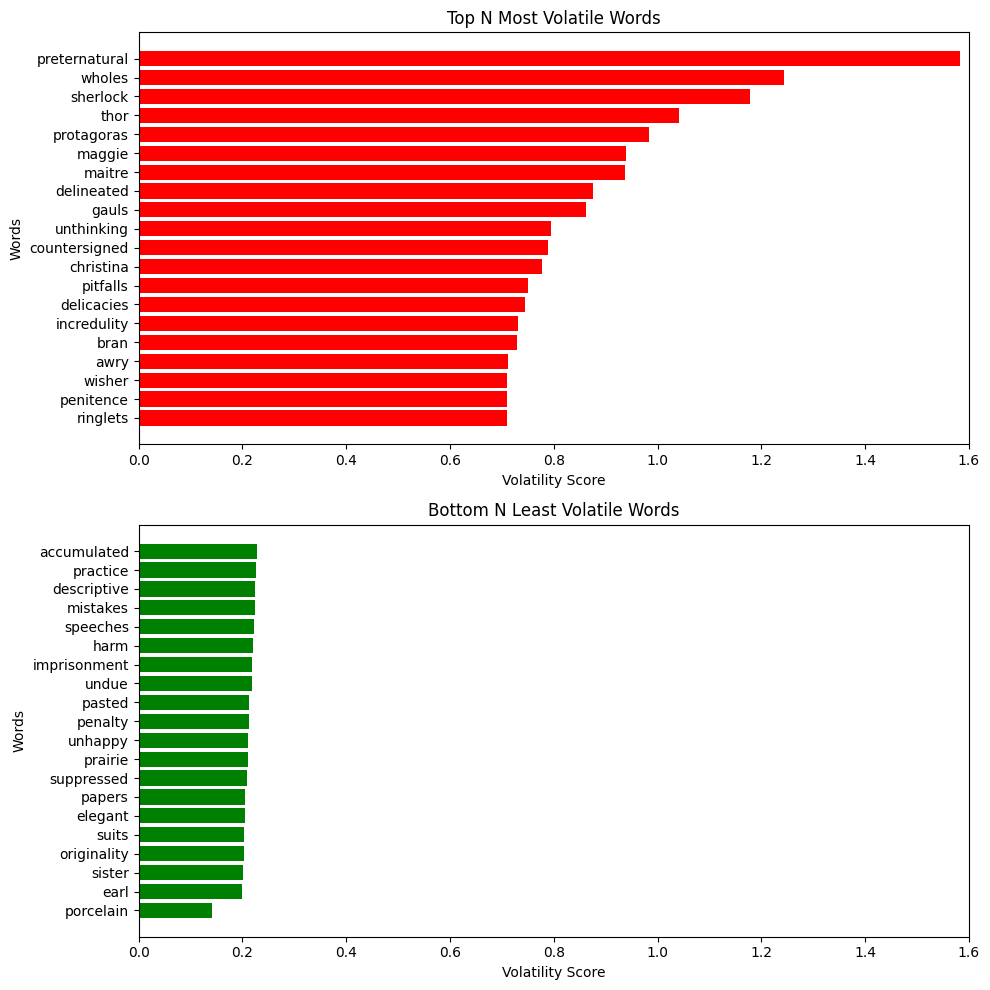

In [228]:
N = 20 # num words to display for top/bottom volatility

# extract top N most volatile words
top_volatile_words = sorted_volatility[:N]
top_words, top_scores = zip(*top_volatile_words)

# extract bottom N least volatile words
bottom_volatile_words = sorted_volatility[-N:]
bottom_words, bottom_scores = zip(*bottom_volatile_words)

# find maximum score across both top/bottom for consistent scaling
max_score = max(max(top_scores), max(bottom_scores))

# calculate next highest interval to use for x-axis bounds
interval_step = 0.2  # Choose a step that makes sense for your data (e.g., 0.5, 1, etc.)
max_score_rounded = math.ceil(max_score / interval_step) * interval_step

# plot it
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# plotting top N most volatile words
ax[0].barh(top_words, top_scores, color='red')
ax[0].invert_yaxis()  # Highest score on top
ax[0].set_title('Top N Most Volatile Words')
ax[0].set_xlabel('Volatility Score')
ax[0].set_ylabel('Words')
ax[0].set_xlim(0, max_score_rounded)

# plotting bottom N least volatile words
ax[1].barh(bottom_words, bottom_scores, color='green')
ax[1].invert_yaxis()  # Highest score on top
ax[1].set_title('Bottom N Least Volatile Words')
ax[1].set_xlabel('Volatility Score')
ax[1].set_ylabel('Words')
ax[1].set_xlim(0, max_score_rounded)

plt.tight_layout()
plt.show()

#### Quantify Changes in Co-Occurence of Select Words Using Jaccard Similarity:

In [ ]:
def cosine_similarity(vec1, vec2):
    # calculate the dot product
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    
    # calculate L2 norm for each vector
    norm_vec1 = l2_norm(vec1)
    norm_vec2 = l2_norm(vec2)

    # handle division by zero if any of the vectors have zero magnitude
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0

    # calculate cosine similarity
    return dot_product / (norm_vec1 * norm_vec2)

In [255]:
def calculate_jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    
    Parameters:
    set1, set2: Sets representing co-occurring words for a target word.

    Returns:
    float: Jaccard similarity between the two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

In [256]:
def extract_cooccurrence_sets(embeddings_dict, vocab_dict, threshold=0.5):
    cooccurrence_dict = {}

    # traverse through each decade to find neighbors of words
    for decade, embeddings in embeddings_dict.items():
        cooccurrence_dict[decade] = {}

        for idx, word in enumerate(vocab_dict[decade]):
            target_vector = embeddings[idx]

            # findings neighbors based on cosine similarity
            neighbors = set()
            for j, other_vector in enumerate(embeddings):
                if idx != j:
                    similarity = cosine_similarity(target_vector, other_vector)
                    if similarity >= threshold:
                        neighbors.add(vocab_dict[decade][j])
            cooccurrence_dict[decade][word] = neighbors

    return cooccurrence_dict

In [257]:
def calculate_jaccard_scores(cooccurrence_dict):
    jaccard_scores = {}

    decades = sorted(cooccurrence_dict.keys())

    # traverse each word in vocab dict
    for word in vocab_dict[decades[0]]:
        jaccard_similarities = []

        # compute Jaccard similarity for each consecutive decade pair
        for i in range(len(decades) - 1):
            set1 = cooccurrence_dict[decades[i]].get(word, set())
            set2 = cooccurrence_dict[decades[i + 1]].get(word, set())

            jaccard_similarity = calculate_jaccard_similarity(set1, set2)
            jaccard_similarity = round(jaccard_similarity, 3) # truncate value here to 3 decimal places
            jaccard_similarities.append(jaccard_similarity)

        jaccard_scores[word] = jaccard_similarities

    return jaccard_scores


In [258]:
# extract co-occurrence sets with a given similarity threshold
cooccurrence_dict = extract_cooccurrence_sets(proj_embeddings_dict, vocab_dict, threshold=0.9)

# calculate Jaccard scores
jaccard_scores = calculate_jaccard_scores(cooccurrence_dict)

# display Jaccard similarities for each word across each decade pair (debugging)
for word, scores in jaccard_scores.items():
    print(f"Jaccard similarities for '{word}' across decades: {scores}")

Jaccard similarities for 'tariffs' across decades: [0.538, 0.333, 0.421, 0.692, 0.667, 0.643, 0.667, 0.462, 0.353, 0.688]
Jaccard similarities for 'flannel' across decades: [0.438, 0.217, 0.5, 0.606, 0.531, 0.448, 0.615, 0.692, 0.593, 0.429]
Jaccard similarities for 'caldwell' across decades: [0.696, 0.65, 0.824, 0.652, 0.652, 0.591, 0.68, 0.654, 0.56, 0.63]
Jaccard similarities for 'lunatic' across decades: [0.538, 0.5, 0.4, 0.375, 0.533, 0.0, 0.0, 0.0, 0.077, 0.125]
Jaccard similarities for 'pharmacopoeia' across decades: [0.3, 0.333, 0.222, 0.077, 0.3, 0.556, 0.429, 0.5, 0.222, 0.154]
Jaccard similarities for 'admirer' across decades: [0.267, 0.615, 0.267, 0.417, 0.077, 0.125, 0.286, 0.4, 0.6, 0.625]
Jaccard similarities for 'failing' across decades: [0.435, 0.286, 0.368, 0.591, 0.652, 0.417, 0.5, 0.6, 0.444, 0.56]
Jaccard similarities for 'denoting' across decades: [0.273, 0.115, 0.611, 0.667, 0.393, 0.417, 0.75, 0.583, 0.5, 0.44]
Jaccard similarities for 'uphold' across decades: [

In [259]:
import seaborn as sns

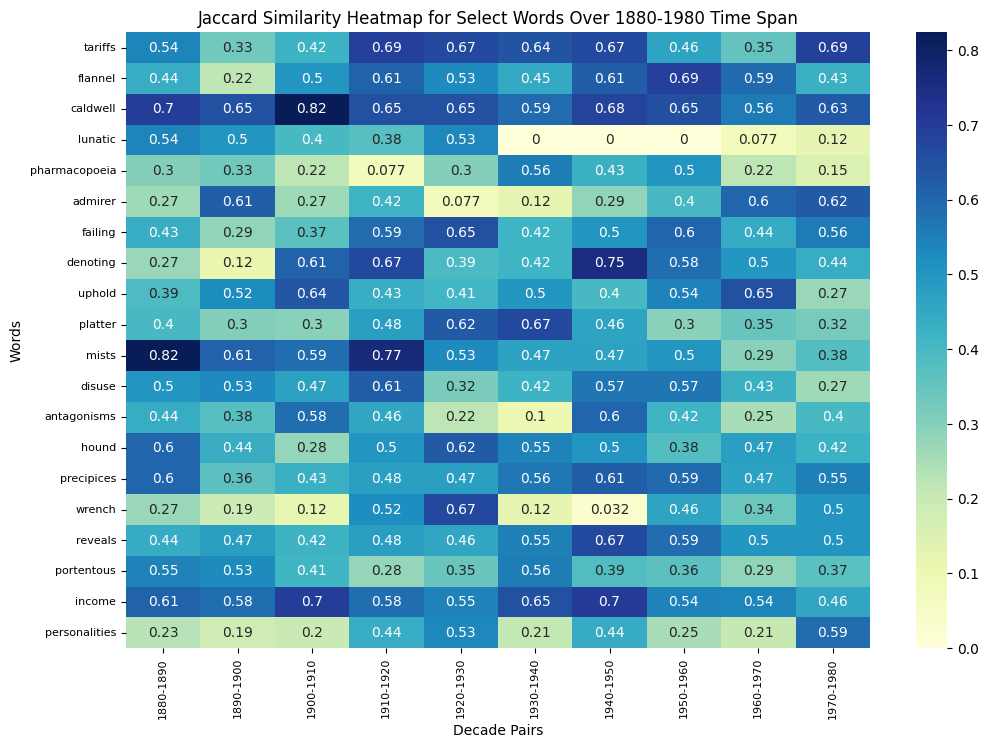

In [272]:
N = 20 # num words to display for Jaccard similarity heatmap
selected_words = list(jaccard_scores.keys())[:N]

# create heatmap data
heatmap_data = [jaccard_scores[word] for word in selected_words]
decades_labels = [f"{decades[i]}-{decades[i + 1]}" for i in range(len(decades) - 1)]

# plot heatmap
plt.figure(figsize=(12, 8))

ax = sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", xticklabels=decades_labels, yticklabels=selected_words)

# font size of axis tick labels
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.title("Jaccard Similarity Heatmap for Select Words Over 1880-1980 Time Span")
plt.xlabel("Decade Pairs")
plt.ylabel("Words")
plt.show()

In [261]:
text_size = 8
marker_size = 3

# camera zoom control
camera = dict(
    eye=dict(x=1.5, y=1.5, z=1.5)  # adjust for zoom level (default is x=1, y=1, z=1)
)

In [270]:
N = 20 # num words to display for Jaccard similarity 3D line plot
selected_words = list(jaccard_scores.keys())[:N]
decade_pairs = [f"{decades[i]}-{decades[i + 1]}" for i in range(len(decades) - 1)]

# traces for 3D plot
data = []

for idx, word in enumerate(selected_words):
    # X, Y, Z coordinates for each word's Jaccard similarity across decades
    X = [idx] * len(jaccard_scores[word])       # word index for all points
    Y = decade_pairs                            # represents time in decades
    Z = jaccard_scores[word]                    # Jaccard similarity score

    trace = go.Scatter3d(
        x=X,
        y=list(range(len(decade_pairs))),
        z=Z,
        mode='lines+markers',
        name=word,
        line=dict(width=3),
        marker=dict(size=marker_size)
    )
    data.append(trace)

layout = go.Layout(
    title="3D Jaccard Similarity Trend Lines for Select Words Over 1880-1980 Time Span",
    title_x=0.5,
    scene=dict(
        xaxis=dict(
            title="Words",
            tickvals=list(range(N)),
            ticktext=selected_words,
            tickfont=dict(size=10),
        ),
        yaxis=dict(
            title="Decade Pairs",
            tickmode='array',
            tickvals=list(range(len(decade_pairs))),
            ticktext=decade_pairs,
            tickfont=dict(size=10),
        ),
        zaxis=dict(
            title="Jaccard Similarity Score",
            tickfont=dict(size=10),
            ),
        aspectratio=dict(x=1, y=1, z=1),
        camera=camera,
    ),
    height=800,
    width=1000,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
